In [1]:
from braincoder.utils.data import load_szinte2024
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.optimize import ResidualFitter
from braincoder.hrf import SPMHRFModel

In [2]:
ds = load_szinte2024(best_voxels=200)

In [3]:
stimulus = ds['stimulus']
grid_coordinates = ds['grid_coordinates']
tr = ds['tr']
prf_pars = ds['prf_pars']
data = ds['v1_timeseries']


model = GaussianPRF2DWithHRF(grid_coordinates=grid_coordinates,
                      paradigm=stimulus,
                      parameters=prf_pars,
                    hrf_model=SPMHRFModel(tr=tr))

In [4]:
resid_fitter = ResidualFitter(model, data, stimulus, parameters=prf_pars)
omega, dof = resid_fitter.fit()

init_tau: 0.24367155134677887, 0.5992619395256042
USING A PSEUDO-WWT!
WWT max: 0.007492970209568739


  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
from braincoder.optimize import StimulusFitter
stim_fitter = StimulusFitter(data, model, omega)


# Note how we use the original stimulus as a mask to only fit the stimulus at the locations where it was actually presented
reconstructed_stimulus = stim_fitter.fit(legacy_adam=True, min_n_iterations=1000, max_n_iterations=2000, learning_rate=.05, mask=(stimulus > 0.1))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

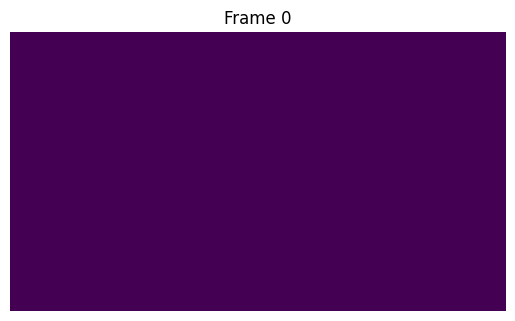

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

def play_reconstruction(reconstructed_stimulus):

  # Here we make a movie of the decoded stimulus
  # Set up a function to draw a single frame
  vmin, vmax = 0.0, np.quantile(reconstructed_stimulus.values.ravel(), 0.99)

  def update(frame):
      plt.clf()  # Clear the current figure
      plt.imshow(reconstructed_stimulus.loc[frame].values.reshape((stimulus.shape[1:])).T, cmap='viridis', vmin=vmin, vmax=vmax, origin='upper')
      plt.axis('off')
      plt.title(f"Frame {frame}")

  # Create the animation
  fig = plt.figure()
  ani = FuncAnimation(fig, update, frames=range(stimulus.shape[0]), interval=100)

  return HTML(ani.to_html5_video())

play_reconstruction(reconstructed_stimulus)